<img src="files/night_sky_eye_small.jpg">
# Image_comparison Script

Jessica Metzger (UChicago) and Jim Annis (Fermilab) 2018


To run this notebook:
  * the geckodriver executable needs to be in the environmental variable $PATH
      **export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/
  * you'll need to run 
       ** conda activate des18a"
  * and set the python path:
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python;export PYTHONPATH;
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages;export PYTHONPATH;
       
 *(to run a notebook remotely, see 
 http://home.fnal.gov/~kadrlica/fnalstart.html
 
 ## How this should work
 
 * Given a search image:
 * Select from the 200mpc catalog the likely galaxies in the image as a list of ra,dec's
 * If in panstarrs area, run the current script for each ra, dec
     ** teach this code to know where the search image is
 * If we want to see DECam template images
 ** find the DECam images that overlap (from the diffimage pipeline or from Alex)
 *** teach the code to accept a list of template DECam images
 ** teach the code to look there for those images and deal gracefully with no matches
     *** where is there? ideally all the DECam images are on disk at Fermilab. There.


In [3]:
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time,os
import glob
import fitsio

#import ps1
import support

In [97]:
# 
# given a ra,dec of a search image, 
# return the list of gals and thumbs
#
def get_list_of_gals_and_cutouts(ra,dec, path_to_cutouts="/data/des70.a/data/annis/s190510/", verbose=False) :
    file = glob.glob(path_to_cutouts + "matched*csv")
    dc_ra, dc_dec = np.genfromtxt(file[0],unpack=True,usecols=(0,1),delimiter=",", skip_header=1)
    thumb = np.genfromtxt(file[0],unpack=True,usecols=(3),delimiter=",",skip_header=1,dtype="str")
    
    distance = np.sqrt( ((ra-dc_ra)*np.cos(dc_dec*2*np.pi/360.))**2 + (dec-dc_dec)**2)
    #distance = support.gc_separation(ra, dec, dc_ra, dc_dec)
    ix = distance < 1.2
    gals_ra, gals_dec = dc_ra[ix], dc_dec[ix]
    for i in range(gals_ra.size):
        if verbose:
            print "{} {:10.5f} {:10.5f} \t {}".format(i, gals_ra[i], gals_dec[i], thumb[ix][i])
    return gals_ra, gals_dec, thumb[ix]
    
# 
# given a thumb name, return image
# return the list of gals and thumbs
#
def get_des_cutout_image(thumb_name, filter="g", path_to_cutouts="/data/des70.a/data/annis/s190510/") :
    fits = fitsio.FITS(path_to_cutouts+thumb_name+"_{}.fits".format(filter))
    img = fits[0].read()
    return img

In [98]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS

def raw_cutout(infilename, ra,dec,stampSize, verbose=True): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    
    found = False
    for ccd in range(1,63):
        if verbose: print ccd,
        header = fits.open(infilename)[ccd].header #pyfits.getheader(infilename, 0)
        #print header
        data = fits.open(infilename)[ccd].data
        try:
            ylen, xlen = data.shape[0], data.shape[1]
        except:
            if verbose: print "no data"
            continue
    
        #Find pixel at the candidate ra dec
        w = WCS(header=header) 
        for i in range(0,ra.size) :
        px, py = w.all_world2pix(ra, dec, 1)
        objcoord = [px, py]
        if np.isnan(px) or np.isnan(py):
            if verbose: print "isnan"
            continue
        corners = w.calc_footprint()
        if (px < -1024 or px > 1024): continue
        if (py < -2048 or py > 2048): continue 
        print corners
        print ra,dec
        found = True
        if found: 
            print objcoord
            break
        
    if verbose: 
        if not found: 
            print "Not Found"
            return -1

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    if verbose: print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def cutout(infilename,ra,dec,stampSize): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]
   

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def find_BLISS_image(cand_ra,cand_dec,stampSize):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if not os.path.isfile(cat_file):
            print "There is no source catalog in ", band
            exp_file = 0
            return ""
        else:
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                img = cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
                img = np.rot90(img)
                img = np.fliplr(img)
      
            return img
    
def find_search_image(image_name, cand_ra,cand_dec,stampSize, dir="/data/des51.b/data/DTS/src/20190510/"):
    exp_file = dir+image_name
    img = raw_cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
    try:
        if img == -1: return -1
    except:
        img = np.rot90(img)
        img = np.fliplr(img)
      
    return img



In [198]:
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def work_image(expid, image_ra,image_dec, filter="g",
               dir="/data/des51.b/data/DTS/src/20190510/", 
               do_bliss=False, do_cutout=True, verbose=True): #Stampsize is half width
    infilename = dir + "DECam_00{}.fits.fz".format(expid)

    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    
    gra,gdec,thumbs = get_list_of_gals_and_cutouts(image_ra, image_dec)
    match_cutout = 15
    go_big = 25
    #match_cutout = 15
    if do_cutout: stampSize = match_cutout/0.27
    if do_bliss:   stampSize = go_big/0.27

    for ccd in range(1,63):
        if verbose: print ccd,
        header = fits.open(infilename)[ccd].header #pyfits.getheader(infilename, 0)
        #print header
        data = fits.open(infilename)[ccd].data
        try:
            ylen, xlen = data.shape[0], data.shape[1]
        except:
            if verbose: print "no data"
            continue
    
        #Find pixel at the candidate ra dec
        w = WCS(header=header) 
        for i in range(0,gra.size) :
            found = False
            px, py = w.all_world2pix(gra[i], gdec[i], 1)
            objcoord = [px, py]
            if np.isnan(px) or np.isnan(py):
                if verbose: print "isnan"
                continue
            corners = w.calc_footprint()
            #if (px < 0 or px > 2048): continue
            #if (py < 0 or py > 4096): continue 

            ccd_ra_min = corners[:,0].min()
            ccd_ra_max = corners[:,0].max()
            ccd_dec_min = corners[:,1].min()
            ccd_dec_max = corners[:,1].max()
            #print ccd_ra_min, gra[i],ccd_ra_max
            #print ccd_dec_min, gdec[i], ccd_dec_max
            if ((gra[i] < ccd_ra_min) or (gra[i] > ccd_ra_max)) :  continue
            if ((gdec[i] < ccd_dec_min) or (gdec[i] > ccd_dec_max)) :  continue
    
            #cutting image:
            X = int(px)
            Y = int(py+80)
            sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
            sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
            siz = int(np.min(np.array([sizy,sizx])))
            if verbose: print "cutout:",siz,px,py

            data = data[Y-siz:Y+siz+1,X-siz:X+siz+1] 
            data = np.rot90(data)
            data = np.fliplr(data)
            search = data
     

            fig,axs=plt.subplots(1,2,figsize=(15,5))
            axs=axs.ravel()
            fig.suptitle('RA = '+str(round(gra[i],6))+', DEC = '+str(round(gdec[i],6)))
    
                
            if do_cutout :
                template = get_des_cutout_image(thumbs[i], filter=filter)
                label = "DES coadd"
    
            if do_bliss:
                template = find_BLISS_image(gra[i],gdec[i],stampSize)
                label = "Bliss single exposure"

            try:
                axs[0].imshow(np.log10(template-np.amin(template)+1),origin='lower',cmap='gray')
                axs[0].set_title('template for gal {} {}'.format(i, label))
                axs[1].imshow(np.log10(search-np.amin(search)+1),origin='lower',cmap='gray')
                axs[1].set_title('search for gal {}'.format(i))
                plt.show()
            except:
                pass

Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856743.fits.fz
1 2 3 cutout: 92 966.6180371427422 863.2855685126552
Exposure available in  g
Closest object is at distance [0d00m00.2625s]
(RA,DEC)= 86.90868205222675 -30.40666039437395
Filter, mag, magerr g 15.938032 0.0011408024
Opening file: /data/des61.b/data/BLISS/272500/272570/D00272570_g_14_r1p1_immask.fits.fz
cutout: 92 1665.1023196444257 3818.7988809936624


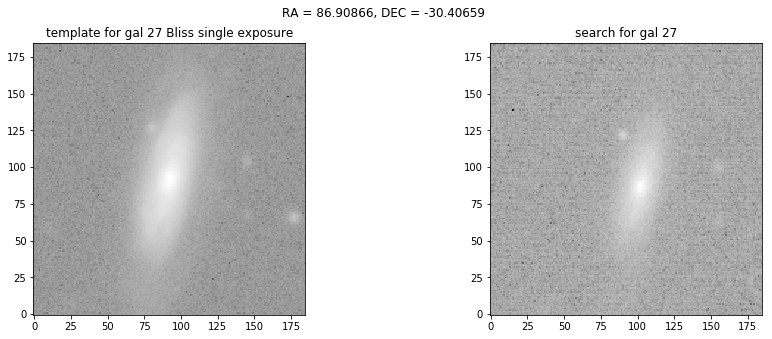

4 5 6 7 8 cutout: 92 1449.4677899288313 1937.2185509604483
Exposure available in  g
Closest object is at distance [0d00m18.5637s]
(RA,DEC)= 86.81511770515512 -30.274861432850024
Filter, mag, magerr g 21.954456 0.051864732
Opening file: /data/des61.b/data/BLISS/514200/514220/D00514220_g_59_r1p1_immask.fits.fz
cutout: 92 1122.7426777541496 286.0505695536077


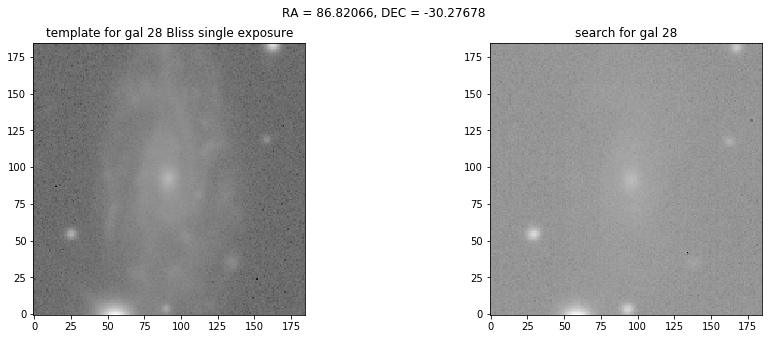

cutout: 92 614.457099096544 3301.900157610872
Exposure available in  g
Closest object is at distance [0d00m00.1992s]
(RA,DEC)= 86.93662014071622 -30.216339647437227
Filter, mag, magerr g 16.846228 0.0020828934
Opening file: /data/des61.b/data/BLISS/514200/514220/D00514220_g_59_r1p1_immask.fits.fz
cutout: 92 302.0249175753852 1661.1423236061432
9 10 11 12 13 14 15 16 cutout: 92 341.9574406533766 2296.4957612122967
Exposure available in  g
Closest object is at distance [0d00m00.425s]
(RA,DEC)= 86.84592795688975 -30.854334401959477
Filter, mag, magerr g 16.959545 0.0023095412
Opening file: /data/des61.b/data/BLISS/514200/514254/D00514254_g_06_r1p1_immask.fits.fz
cutout: 92 1503.1204987524015 2362.5639052911274


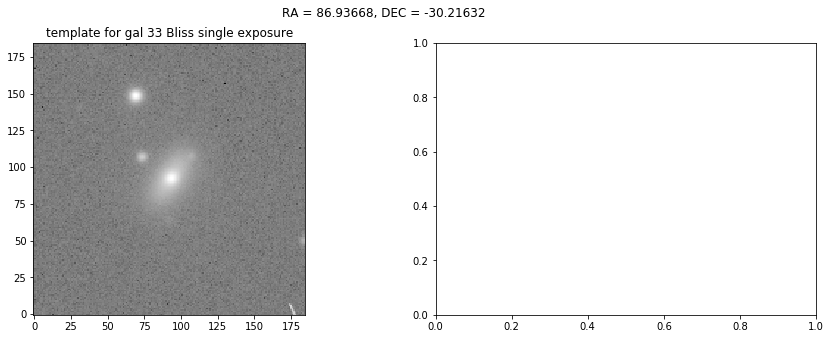

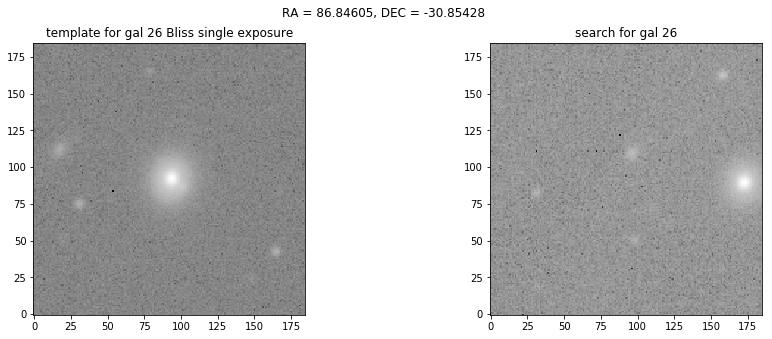

17 18 19 cutout: 92 2072.575469570771 433.962900853486
Exposure available in  g
Closest object is at distance [0d00m00.598s]
(RA,DEC)= 87.05292225792186 -30.32353092065141
Filter, mag, magerr g 16.433348 0.0012623807
Opening file: /data/des61.b/data/BLISS/272500/272570/D00272570_g_15_r1p1_immask.fits.fz
cutout: 92 525.3783479305539 1265.6720980513933


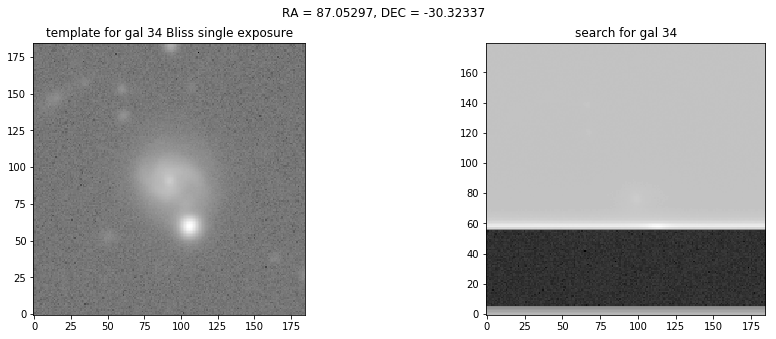

20 21 22 23 24 cutout: 92 1707.2517492043908 1771.633282606044
Exposure available in  g
Closest object is at distance [0d00m00.5888s]
(RA,DEC)= 88.24535415542326 -30.13279033718282
Filter, mag, magerr g 15.842131 0.0017305837
Opening file: /data/des61.b/data/BLISS/719700/719705/D00719705_g_19_r1p1_immask.fits.fz
cutout: 92 602.5830694429578 1346.2650431083443


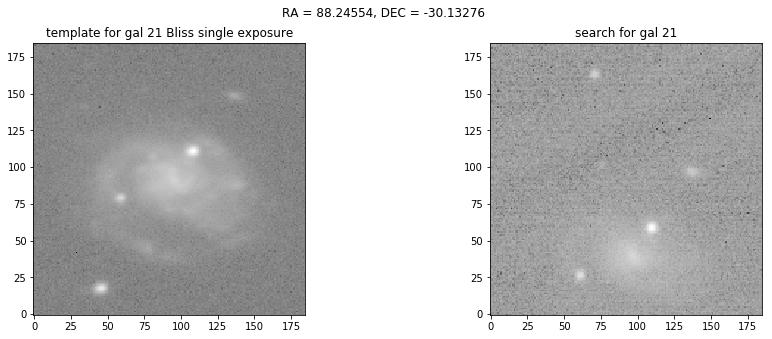

25 26 27 28 29 cutout: 92 912.157916226146 2788.6408525433435
Exposure available in  g
Closest object is at distance [0d00m00.4533s]
(RA,DEC)= 87.79243446703161 -29.91091588329997
Filter, mag, magerr g 17.328 0.0014828385
Opening file: /data/des61.b/data/BLISS/272500/272571/D00272571_g_03_r1p1_immask.fits.fz
cutout: 92 1640.3547505479037 3685.9394621237143


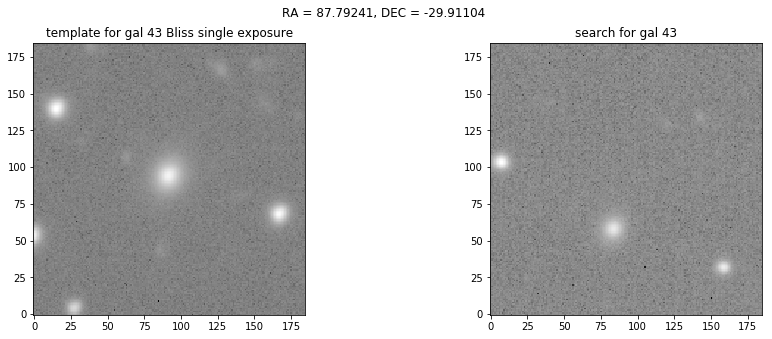

30 31 32 33 34 35 cutout: 92 1425.3176298512171 522.0317779730342
Exposure available in  g
Closest object is at distance [0d00m00.6543s]
(RA,DEC)= 87.24385365456502 -29.619697448392245
Filter, mag, magerr g 16.992865 0.0033173796
Opening file: /data/des61.b/data/BLISS/499400/499494/D00499494_g_24_r1p1_immask.fits.fz
cutout: 92 1754.3255785735319 1970.6895299662963


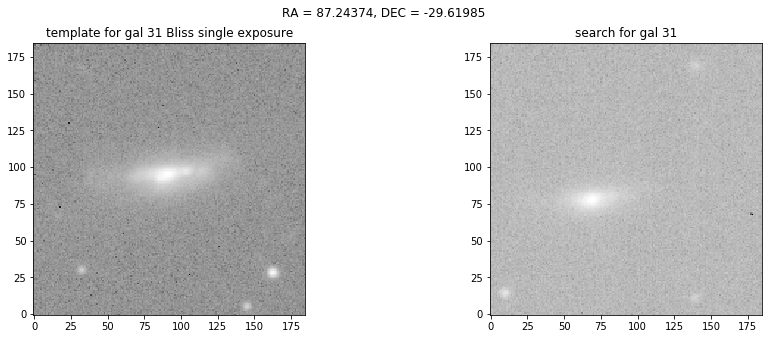

36 37 38 39 40 cutout: 92 464.6829494556731 822.3892036795274
Exposure available in  g
Closest object is at distance [0d00m00.6642s]
(RA,DEC)= 88.34732161296662 -30.534667268292786
Filter, mag, magerr g 17.516592 0.0030352206
Opening file: /data/des61.b/data/BLISS/612700/612724/D00612724_g_32_r1p1_immask.fits.fz
cutout: 92 1406.7344308308438 2267.2429363739907


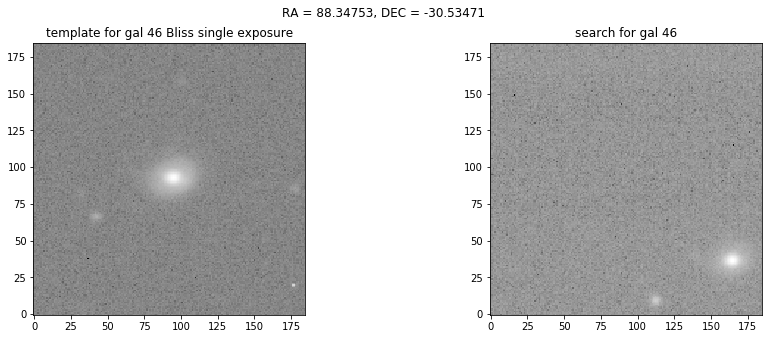

41 42 43 cutout: 92 1550.907729374795 1382.8472376151494
Exposure available in  g
Closest object is at distance [0d00m00.4063s]
(RA,DEC)= 88.03509691215811 -30.45097842115739
Filter, mag, magerr g 15.001691 0.0012047475
Opening file: /data/des61.b/data/BLISS/718900/718991/D00718991_g_10_r1p1_immask.fits.fz
cutout: 92 1796.8600044958248 2074.691411273955


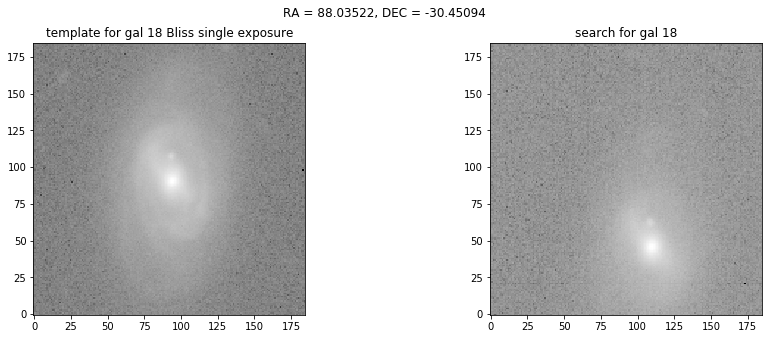

cutout: 92 1440.7155931212938 2908.592061338854
Exposure available in  g
Closest object is at distance [0d00m00.3942s]
(RA,DEC)= 88.16431475786324 -30.442551561984033
Filter, mag, magerr g 16.981062 0.002198813
Opening file: /data/des61.b/data/BLISS/514200/514222/D00514222_g_27_r1p1_immask.fits.fz
cutout: 92 746.2265222533194 3620.8826419422494
44 45 46 cutout: 92 756.1552457281355 581.6126016490954
Exposure available in  g
Closest object is at distance [0d00m00.2486s]
(RA,DEC)= 87.42531749420819 -30.72266107286383
Filter, mag, magerr g 15.465662 0.001335578
Opening file: /data/des61.b/data/BLISS/718900/718991/D00718991_g_20_r1p1_immask.fits.fz
cutout: 92 1021.7229976894278 1282.3966812555855


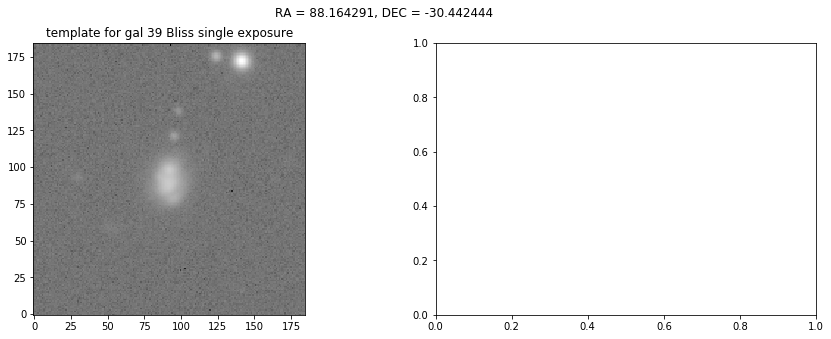

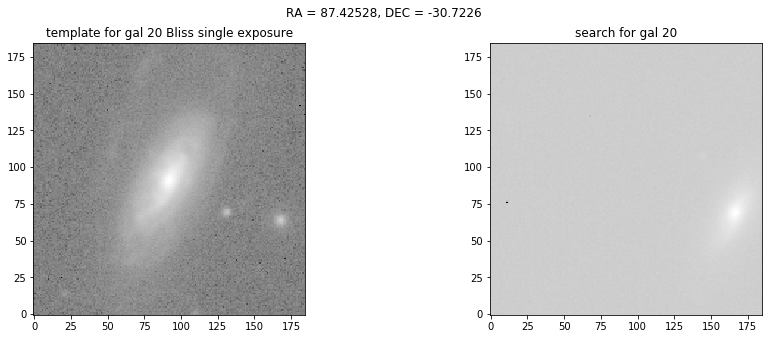

cutout: 92 436.7357958067596 1317.0408479095329
Exposure available in  g
Closest object is at distance [0d00m00.3394s]
(RA,DEC)= 87.48808642615725 -30.6992673287835
Filter, mag, magerr g 17.551403 0.0037644294
Opening file: /data/des61.b/data/BLISS/718900/718991/D00718991_g_20_r1p1_immask.fits.fz
cutout: 92 700.308374677104 2018.5322444955236
47 cutout: 92 1872.7145686402382 81.29396310033101
Exposure available in  g
Closest object is at distance [0d00m00.5048s]
(RA,DEC)= 87.74478526491184 -30.804270071895008
Filter, mag, magerr g 15.491948 0.00075620087
Opening file: /data/des61.b/data/BLISS/272500/272570/D00272570_g_36_r1p1_immask.fits.fz
cutout: 92 354.34775071437247 3021.1273597248446


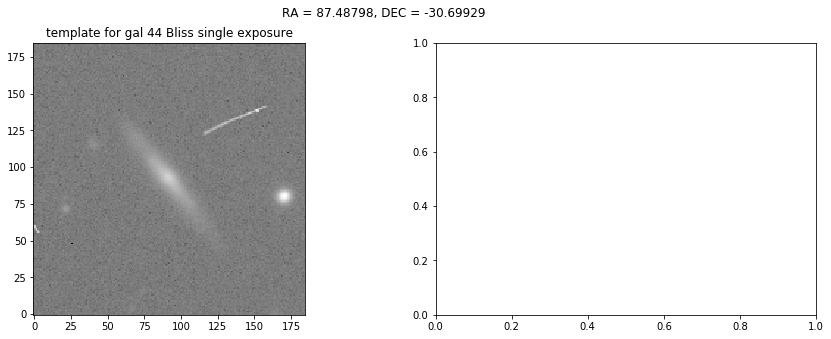

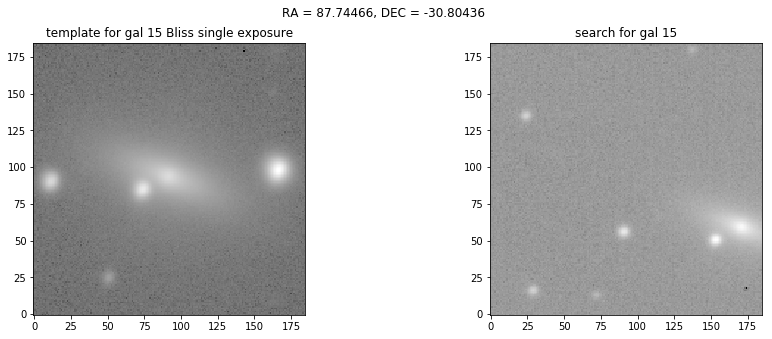

48 cutout: 92 383.96207735013695 922.7410605547448
Exposure available in  g
Closest object is at distance [0d00m00.2243s]
(RA,DEC)= 88.17689378103285 -30.69412470861036
Filter, mag, magerr g 15.186737 0.0010305375
Opening file: /data/des61.b/data/BLISS/611000/611017/D00611017_g_49_r1p1_immask.fits.fz
cutout: 92 261.2315122378732 298.58692959804205


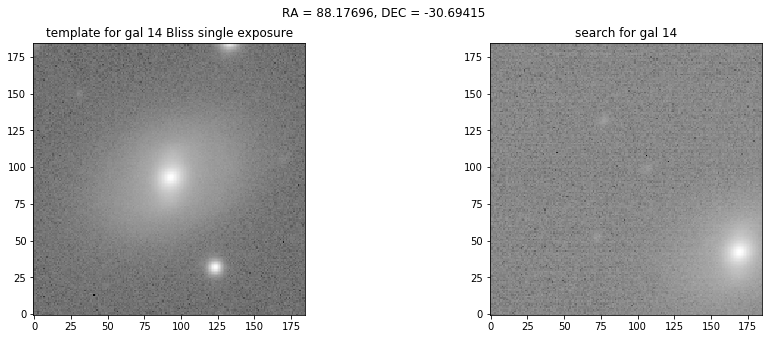

49 50 51 cutout: 92 1005.7018267920557 2541.88467589598
Exposure available in  g
Closest object is at distance [0d00m00.2347s]
(RA,DEC)= 87.22924633922388 -30.904965606666543
Filter, mag, magerr g 15.680288 0.0011312433
Opening file: /data/des61.b/data/BLISS/718900/718991/D00718991_g_26_r1p1_immask.fits.fz
cutout: 92 1278.2967920905623 1116.0261911258128


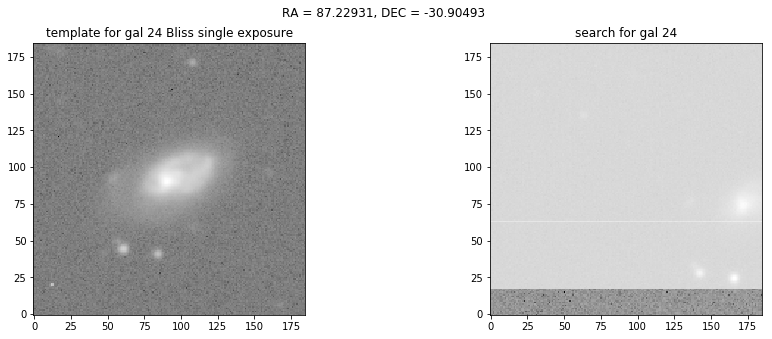

cutout: 92 974.3657254075051 1265.7210216921221
Exposure available in  g
Closest object is at distance [0d00m00.5223s]
(RA,DEC)= 87.12030918141726 -30.902102124337702
Filter, mag, magerr g 16.119625 0.0017789705
Opening file: /data/des61.b/data/BLISS/611000/611017/D00611017_g_51_r1p1_immask.fits.fz
cutout: 92 868.3645415865467 2767.792534914218
52 53 cutout: 92 816.1923806957948 3119.5859634569815
Exposure available in  g
Closest object is at distance [0d00m23.1516s]
(RA,DEC)= 87.08915485707614 -31.055583575831083
Filter, mag, magerr g 22.54208 0.08526325
Opening file: /data/des60.b/data/BLISS/598300/598367/D00598367_g_24_r1p1_immask.fits.fz
cutout: 92 360.1310540397885 4075.1729086555797


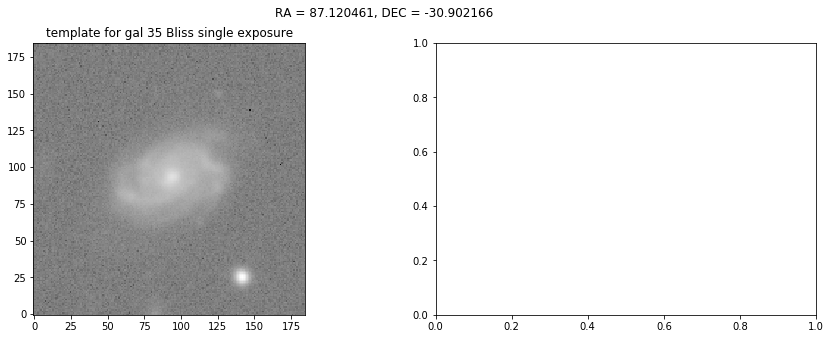

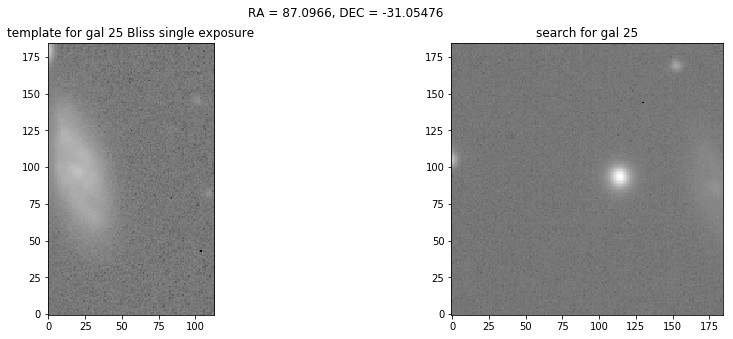

54 cutout: 92 1124.5416532630343 541.2074544426679
Exposure available in  g
Closest object is at distance [0d00m00.2737s]
(RA,DEC)= 87.23944535782145 -31.07787832050872
Filter, mag, magerr g 16.70599 0.002314928
Opening file: /data/des61.b/data/BLISS/704900/704922/D00704922_g_14_r1p1_immask.fits.fz
cutout: 92 1677.57055667011 3402.9640651655736


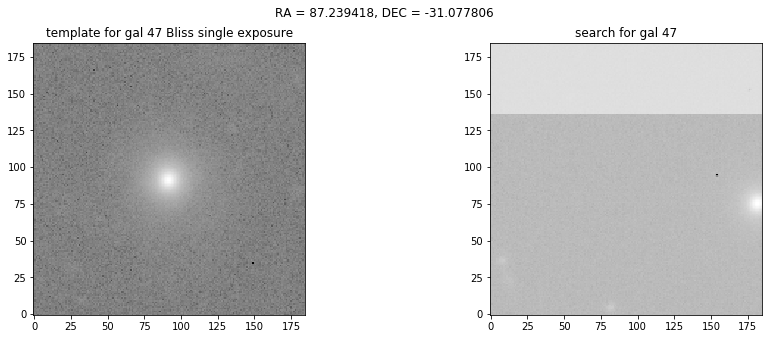

55 cutout: 92 1485.0637522956667 3062.930924879765
Exposure available in  g
Closest object is at distance [0d00m00.3796s]
(RA,DEC)= 87.81761676274847 -31.10472861251317
Filter, mag, magerr g 14.080895 0.0005946925
Opening file: /data/des61.b/data/BLISS/611000/611017/D00611017_g_58_r1p1_immask.fits.fz
cutout: 92 1370.1274593440503 322.2581087559061


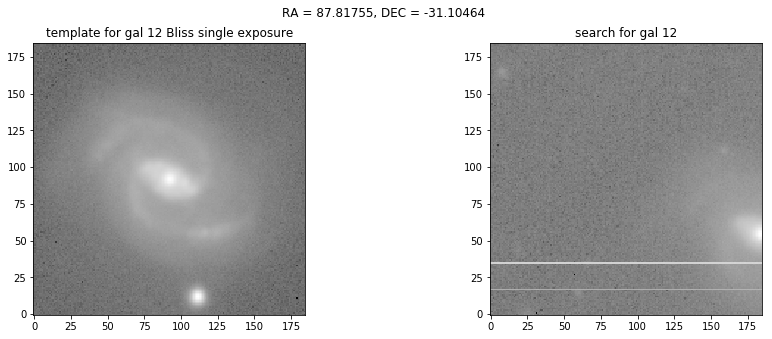

cutout: 92 455.6362419462166 3394.403355087241
Exposure available in  g
Closest object is at distance [0d00m00.4993s]
(RA,DEC)= 87.84569615406917 -31.029372022428802
Filter, mag, magerr g 15.2087145 0.0015726893
Opening file: /data/des61.b/data/BLISS/611000/611017/D00611017_g_58_r1p1_immask.fits.fz
cutout: 92 339.21952909508946 655.1890094290021
56 57 58 59 cutout: 92 1705.2431031432334 4132.059630244333
Exposure available in  g
Closest object is at distance [0d00m00.7525s]
(RA,DEC)= 88.0900893813751 -31.283604704628306
Filter, mag, magerr g 16.208057 0.0015302994
Opening file: /data/des61.b/data/BLISS/718900/718991/D00718991_g_42_r1p1_immask.fits.fz
cutout: 92 1920.9595241667212 581.4817170362006


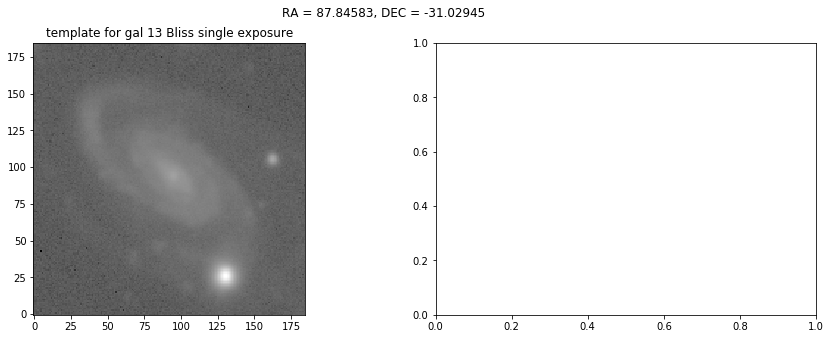

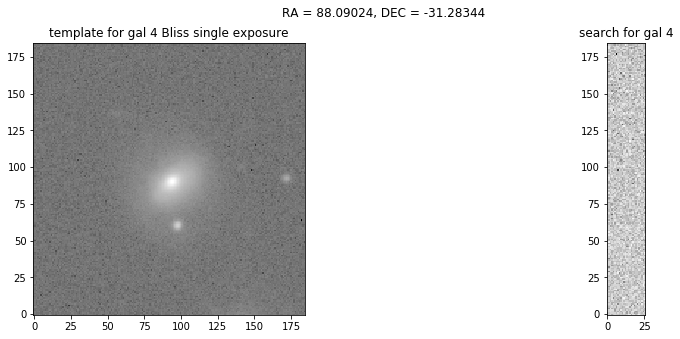

cutout: 92 2138.3299741406354 3182.9189619945637
Exposure available in  g
Closest object is at distance [0d00m00.6119s]
(RA,DEC)= 88.0091962800942 -31.315529942305517
Filter, mag, magerr g 15.630924 0.0007963992
Opening file: /data/des61.b/data/BLISS/272500/272570/D00272570_g_55_r1p1_immask.fits.fz
cutout: 92 614.6858881369826 1840.6065520941104
cutout: 92 676.9795919262924 2885.733901674395
Exposure available in  g
Closest object is at distance [0d00m21.9171s]
(RA,DEC)= 87.99080072555233 -31.20870106893923
Filter, mag, magerr g 21.727243 0.04914627
Opening file: /data/des61.b/data/BLISS/272500/272570/D00272570_g_49_r1p1_immask.fits.fz
cutout: 92 1404.4037444547648 3671.5974906486294
60 cutout: 92 2141.795868721225 163.10744611506829
Exposure available in  g
Closest object is at distance [0d00m00.1688s]
(RA,DEC)= 86.84149137967674 -31.47778655310886
Filter, mag, magerr g 16.252842 0.0018464298
Opening file: /data/des60.b/data/BLISS/598300/598367/D00598367_g_37_r1p1_immask.fits.fz
cutou

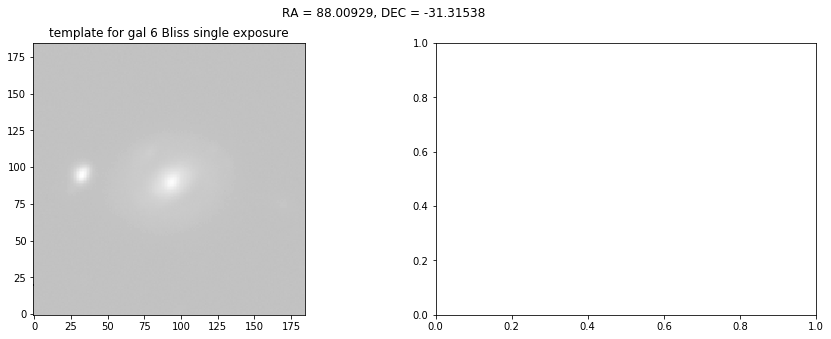

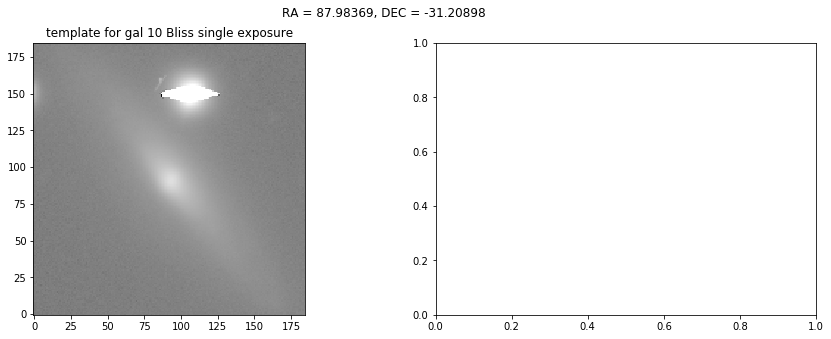

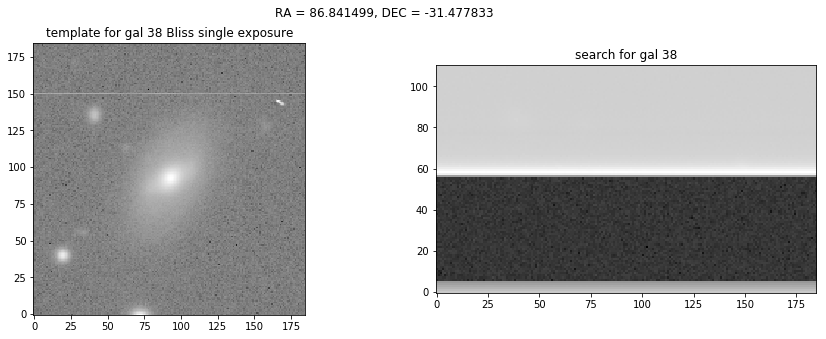

cutout: 92 574.7753454022022 3335.628377660208
Exposure available in  g
Closest object is at distance [0d00m00.2684s]
(RA,DEC)= 87.1137477206857 -31.36542638161569
Filter, mag, magerr g 16.59452 0.0030250847
Opening file: /data/des61.b/data/BLISS/514200/514254/D00514254_g_23_r1p1_immask.fits.fz
cutout: 92 1758.3958873339266 1211.070891018733
61 62 cutout: 92 499.37340277337717 98.88000476513916
Exposure available in  g
Closest object is at distance [0d00m00.356s]
(RA,DEC)= 87.56422713244213 -31.360823981038592
Filter, mag, magerr g 17.177671 0.004035842
Opening file: /data/des61.b/data/BLISS/514200/514254/D00514254_g_24_r1p1_immask.fits.fz
cutout: 92 1730.055946743828 2232.7807247356786


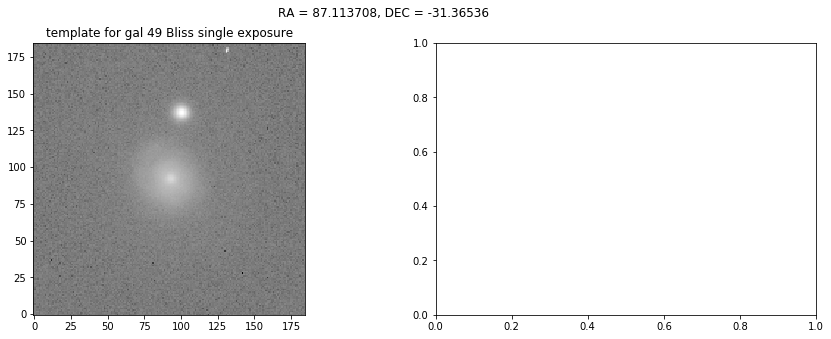

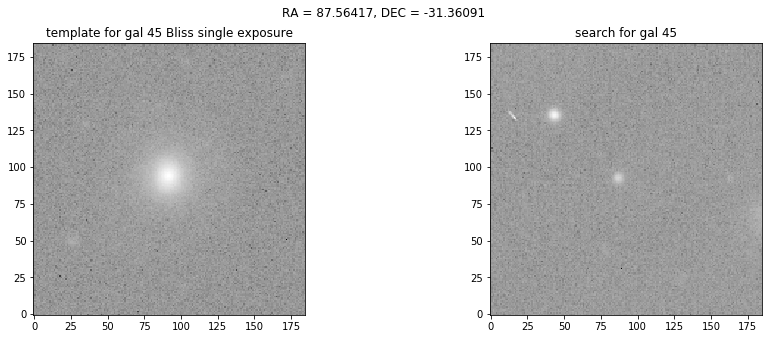

In [199]:
image_ra, image_dec = 87.42528, -30.7226
image_name = "856743"
work_image(image_name, image_ra,image_dec, do_bliss=True, do_cutout=False, verbose=True)

# Do the Eyeballing!

This is the action cell!

For a given image, get the 
image name, ra, dec

Change the triplets,
then run the cell, it will take time to do all of them

Exposure available in  g
Closest object is at distance [0d00m00.425s]
(RA,DEC)= 87.99563215539527 -31.78410788000979
Filter, mag, magerr g 17.56227 0.0035836191
Opening file: /data/des60.b/data/BLISS/598300/598368/D00598368_g_10_r1p1_immask.fits.fz
cutout: 55 899.191496296753 1716.0683675197808
Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856743.fits.fz
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 Not Found


TypeError: Invalid dimensions for image data

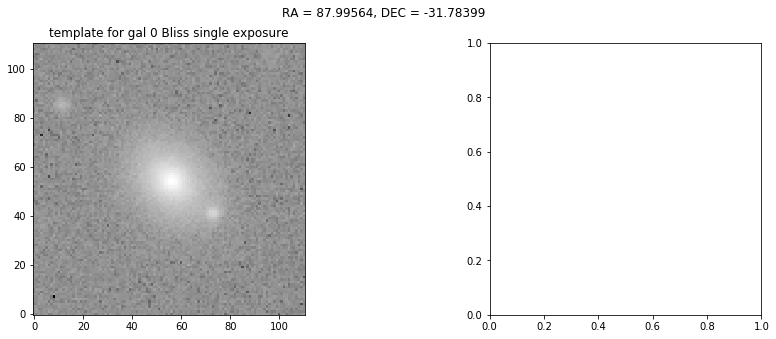

In [99]:
image_ra, image_dec = 87.42528, -30.7226
image_name = "DECam_00856743.fits.fz"
gra,gdec,thumbs = get_list_of_gals_and_cutouts(image_ra, image_dec)

#gra,gdec = np.ones(2)*image_ra, np.ones(2)*image_dec
#thumbs[0] = 'DESJ054942.1-304321.4'
#thumbs[1] = 'DESJ054942.1-304321.4'


pixscal=.27
for i in range(gra.size) :
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(gra[i],6))+', DEC = '+str(round(gdec[i],6)))
    
    match_cutout = 15
    go_big = 25
    if i == 1 :
        template = get_des_cutout_image(thumbs[i])
        label = "DES coadd"
        size = match_cutout/0.27
    
    if i == 0:
        template = find_BLISS_image(gra[i],gdec[i],size)
        label = "Bliss single exposure"
        size = go_big/0.27
    search = find_search_image(image_name,gra[i],gdec[i],size)
    #print search
    #if search == -1 or search == []: continue

    
    axs[0].imshow(np.log10(template-np.amin(template)+1),origin='lower',cmap='gray')
    axs[0].set_title('template for gal {} {}'.format(i, label))
    axs[1].imshow(np.log10(search-np.amin(search)+1),origin='lower',cmap='gray')
    axs[1].set_title('search for gal {}'.format(i))
    plt.show()

In [ ]:

# save new cutout to new folder
def get_search_image(RA,DEC,size,
                     fname="DECam_00850304.fits.fz",
                     path="/data/des51.b/data/DTS/src/20190509/"):
    # open new file
    hdul=fits.open(fname)
    header0=hdul[0].header
    
    for hdu in hdul[1:]:
        header=hdu.header
        img=np.array(hdu.data)
        
        # Parse the WCS keywords in the primary HDU
        w = wcs.WCS(header)
    
        wcoords=np.array([RA,DEC]).reshape((1,2))
        pixs=w.all_world2pix(wcoords,1)[0]
        
        if 0<=pixs[0]<img.shape[1] and 0<=pixs[1]<img.shape[0]:
            
            cutout=np.flip(np.flip(np.array(img[int(max(0,pixs[1]-size/2.)):int(min(img.shape[0],pixs[1]+size/2.)),
                            int(max(0,pixs[0]-size/2.)):int(min(img.shape[1],pixs[0]+size/2.))]),1).transpose(),1)
            
            #write file
            new_filename=path+'RA'+str(RA)+'_DEC'+str(DEC)+'.fits'
            try: fits.writeto(new_filename, cutout, header)
            except OSError:
                try:
                    os.remove(new_filename)
                    fits.writeto(new_filename, cutout, header)
                except OSError:
                    print('file saving error with '+str(RA)+', '+str(DEC))

            return cutout
        
    return 'coordinates not found'

In [ ]:
# example data

new_path='./new_images/'
RA_ls=[88.76485]
DEC_ls=[-33.14772]
    
pixscal=.27
for i in range(len(file_ls)):
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(RA_ls[i],6))+', DEC = '+str(round(DEC_ls[i],6)))
    
#     if not os.path.isfile(template_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    #template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    
#     if not os.path.isfile(new_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    new_cutout=get_search_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,original_path+file_ls[i],template_path)
#     new_cutout=np.array(new_cutout)
    
    axs[0].imshow(np.log10(template_cutout-np.amin(template_cutout)+1),origin='lower',cmap='gray')
    axs[0].set_title('template')
    axs[1].imshow(np.log10(new_cutout-np.amin(new_cutout)+1),origin='lower',cmap='gray')
    axs[1].set_title('new')
    plt.show()

In [ ]:
#Antonella's changes 04/29/2019 to make this work with BLISS images
#This part also finds if there are previous detections of the candidate!

In [ ]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS


def cutout(infilename,ra,dec,stampSize, outfile): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    plt.imshow(data, origin='lower',cmap='gray')
    plt.title('RA='+str(ra)+', DEC='+str(dec))
    #Save outfile

def find_BLISS_image(cand_ra,cand_dec,stampSize):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if os.path.isfile(cat_file):
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                cutout(exp_file,cand_ra,cand_dec,stampSize,outfile) #cand_ra,cand_dec

        else:
            print "There is no source catalog in ", band
            exp_file = 0

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
#AP: Not sure what this does, it was the third entry

# open headless browser
# laptop
# driver=webdriver.Firefox(executable_path='/Users/jmetzger/anaconda3/bin/geckodriver')
# des machines
driver=webdriver.Firefox(executable_path='/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/geckodriver')
browser=Browser(headless=True)
# the geckodriver executable needs to be in the environmental variable $PATH
# export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/

